In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential

from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

2024-12-23 03:21:27.762100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 03:21:27.776302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 03:21:27.780521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 03:21:27.791170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## define the funcitons

In [2]:
def preprocess_data(df):
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['Datetime'] = Datetime

    df.set_index('Datetime', inplace=True)

    df.index = pd.to_datetime(df.index)


    return df

In [3]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):
    
    print('Number of Nans in each column :')
    
    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [4]:
def preprocess_data(df):
    # Creating Datetime index
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['time'] = Datetime

    # Setting Date as the index
    df.set_index('time', inplace=True)

    # Converting the index to a time series
    df.index = pd.to_datetime(df.index)


    return df

In [5]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

In [6]:
def replace_outliers(df):
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])
    return df

In [7]:
def apply_PCA(X_input, n_features=17):
    # Initialize PCA to reduce to a specific number of features
    pca = PCA(n_components=n_features)
    # Apply PCA and MinMaxScaler in a pipeline
    scaler_pca = make_pipeline(pca, MinMaxScaler())
    # Fit and transform the data with PCA and scaling
    X_pca = scaler_pca.fit_transform(X_input)
    
    return X_pca

In [8]:
def windowing(X_input, y_input, history_size, horizon_size):
    data = []
    labels = []
    
    # Loop to create windows of input data and corresponding target values
    for i in range(history_size, len(y_input) - horizon_size + 1):
        # Collect past 'history_size' values for input
        data.append(X_input[i - history_size : i, :])
        
        # Collect next 'horizon_size' values for target
        labels.append(y_input[i : i + horizon_size])
        
    # Convert lists to NumPy arrays for efficient processing
    return np.array(data), np.array(labels)


In [9]:
def reshaping(X):
    
    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

In [10]:
def plot_results_xgboost(y_pred_actual, y_test_inv, evals_result, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    # Plot the predicted vs actual values
    ax[0].plot(y_pred_actual[:24*30])  # Adjust this range based on your data size
    ax[0].plot(y_test_inv[:24*30])  # Adjust this range based on your data size
    ax[0].legend(['Prediction', 'Actual'], loc='upper left')
    ax[0].set_xlabel('Time Period')
    ax[0].set_ylabel('Electricity Energy Consumption [kWh]')
    
    # Plot training and validation MAE from evals_result dictionary
    train_mae = evals_result['train']['mae']
    val_mae = evals_result['eval']['mae']
    ax[1].plot(train_mae, label='Training MAE')
    ax[1].plot(val_mae, label='Validation MAE')

    ax[1].legend()
    ax[1].set_title(f'Training and Validation MAE ({model_name})')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('MAE')    

    fig.tight_layout()
    plt.show()

In [11]:
## Plot Function for Random and LSTM:: 
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:24*30])
    ax[0].plot(y_test_inv[:24*30])
    ax[0].legend(['Prediction', 'Actual'], loc='upper left')
    ax[0].set_xlabel('Time Period')
    ax[0].set_ylabel('Electricity Energy Consumption [kWh]')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    

In [12]:
url= 'https://raw.githubusercontent.com/Forbu/CityLearn-1.3.5/main/citylearn/data/citylearn_challenge_2021/'

In [13]:
#Read csv files
df_b5 = pd.read_csv(f"{url}Building_5.csv")
df_weather = pd.read_csv(f"{url}weather.csv")
df_carbon = pd.read_csv(f"{url}carbon_intensity.csv")

In [14]:
df = df_b5.copy()

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,35040.0,6.526027,3.447901,1.00,4.00,7.00,10.000,12.000
Hour,35040.0,12.500000,6.922285,1.00,6.75,12.50,18.250,24.000
Day Type,35040.0,4.124658,2.083118,1.00,2.00,4.00,6.000,8.000
Daylight Savings Status,35040.0,0.654795,0.475442,0.00,0.00,1.00,1.000,1.000
Indoor Temperature [C],35040.0,22.876750,0.439206,21.48,22.84,23.11,23.110,24.710
Average Unmet Cooling Setpoint Difference [C],35040.0,0.009352,0.049532,0.00,0.00,0.00,0.000,1.600
Indoor Relative Humidity [%],35040.0,53.805154,12.959832,10.18,47.22,57.02,63.210,80.270
Equipment Electric Power [kWh],35040.0,10.170793,2.953384,3.30,8.00,10.00,12.100,31.700
DHW Heating [kWh],35040.0,3.808229,4.980429,0.00,0.60,1.92,4.800,40.080
Cooling Load [kWh],35040.0,25.009796,17.509845,0.00,9.10,24.16,38.580,69.910


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Month                                          35040 non-null  int64  
 1   Hour                                           35040 non-null  int64  
 2   Day Type                                       35040 non-null  int64  
 3   Daylight Savings Status                        35040 non-null  int64  
 4   Indoor Temperature [C]                         35040 non-null  float64
 5   Average Unmet Cooling Setpoint Difference [C]  35040 non-null  float64
 6   Indoor Relative Humidity [%]                   35040 non-null  float64
 7   Equipment Electric Power [kWh]                 35040 non-null  float64
 8   DHW Heating [kWh]                              35040 non-null  float64
 9   Cooling Load [kWh]                             350

In [17]:
df = preprocess_data(df)

In [18]:
df_weather= preprocess_data(df_weather)

In [19]:
df_carbon= preprocess_data(df_carbon)

In [20]:
check_Nans_Dups(df)

Number of Nans in each column :
Month                                                0
Hour                                                 0
Day Type                                             0
Daylight Savings Status                              0
Indoor Temperature [C]                               0
Average Unmet Cooling Setpoint Difference [C]        0
Indoor Relative Humidity [%]                         0
Equipment Electric Power [kWh]                       0
DHW Heating [kWh]                                    0
Cooling Load [kWh]                                   0
Heating Load [kWh]                               35040
Solar Generation [W/kW]                              0
dtype: int64

Number of duplicates in the dataframe : 0


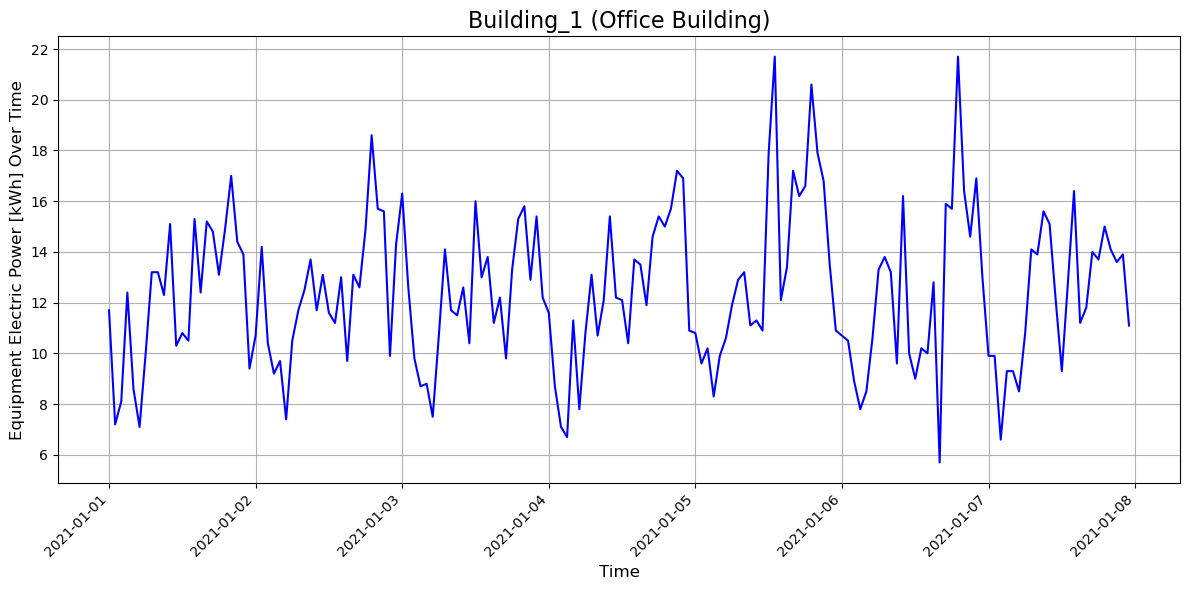

In [21]:
plt.figure(figsize=(12, 6))

# Plot the 'Equipment Electric Power [kWh]' for the first 7 days (24 hours * 7)
plt.plot(df.index[:24*7], df['Equipment Electric Power [kWh]'][:24*7], label='Equipment Electric Power [kWh]', color='blue')

# Add a title and labels with proper formatting
plt.title('Building_1 (Office Building)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Equipment Electric Power [kWh] Over Time', fontsize=12)

# Add grid
plt.grid(True)

# Rotate x-axis labels to ensure they are readable
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


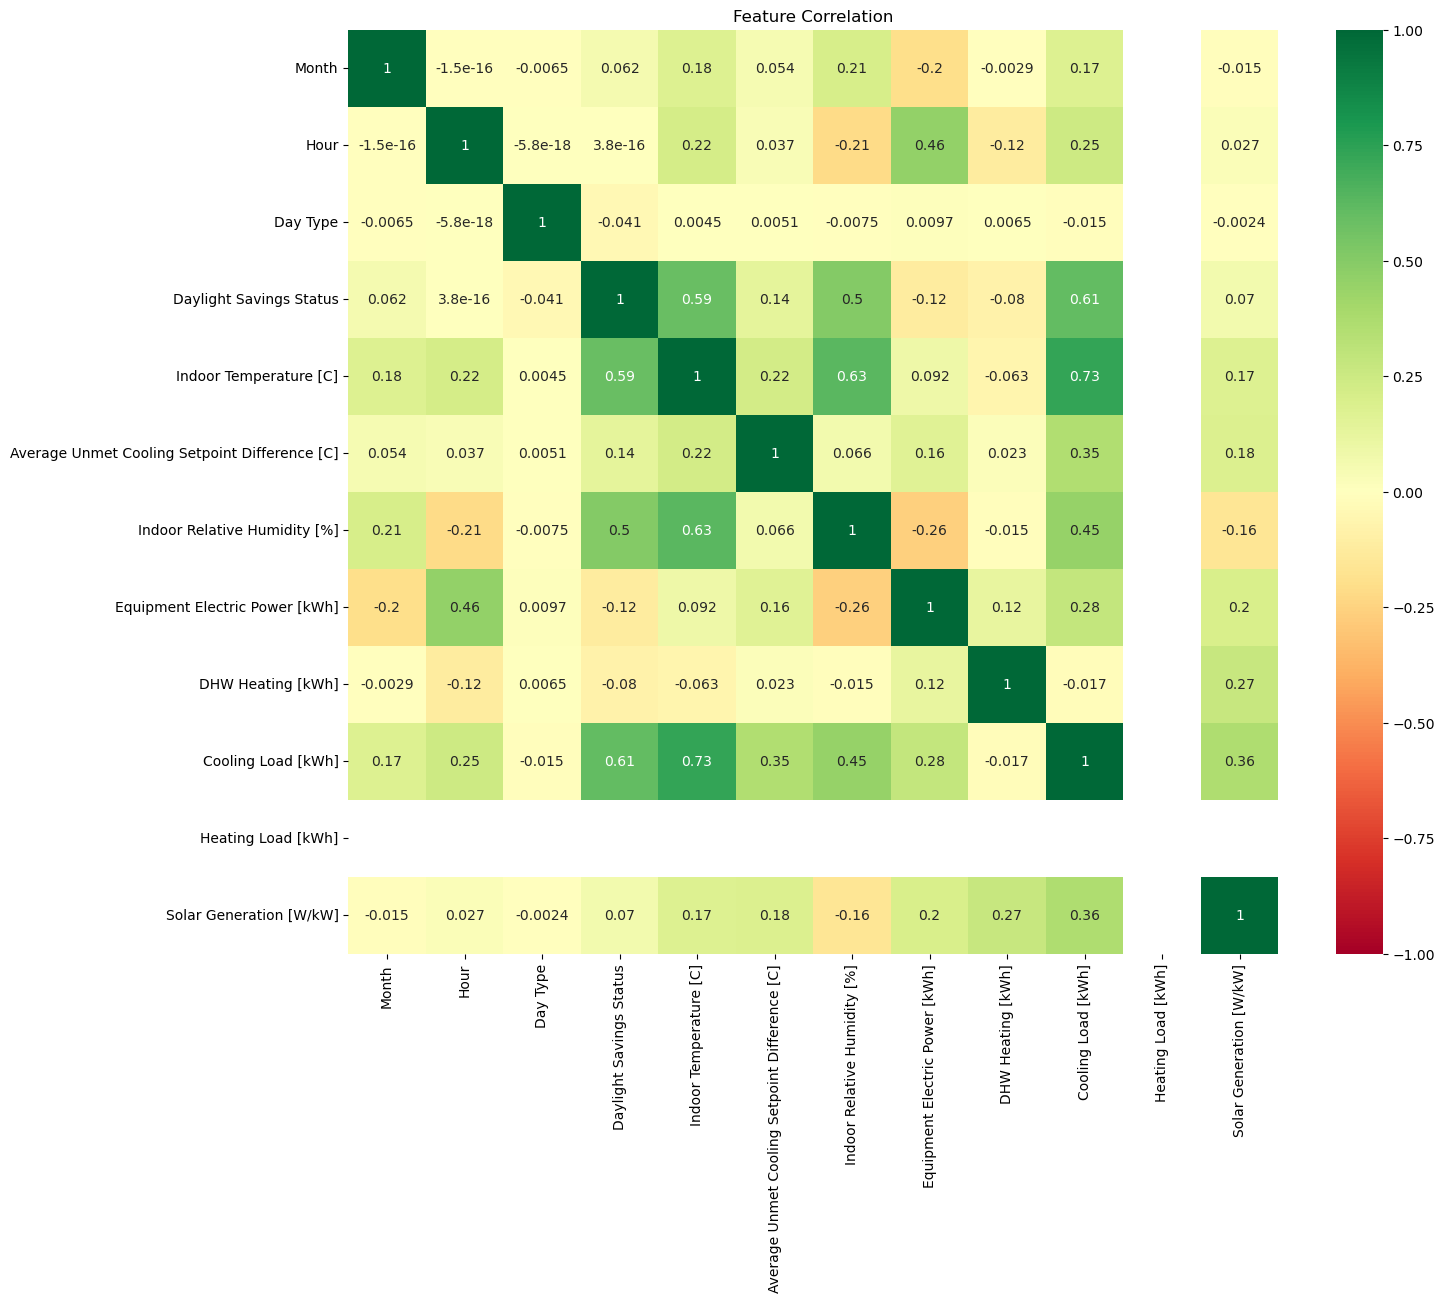

In [22]:
feat_corr(df)

In [23]:
col_drop_name = ['Heating Load [kWh]']

df.drop(col_drop_name, axis = 1 , inplace = True)

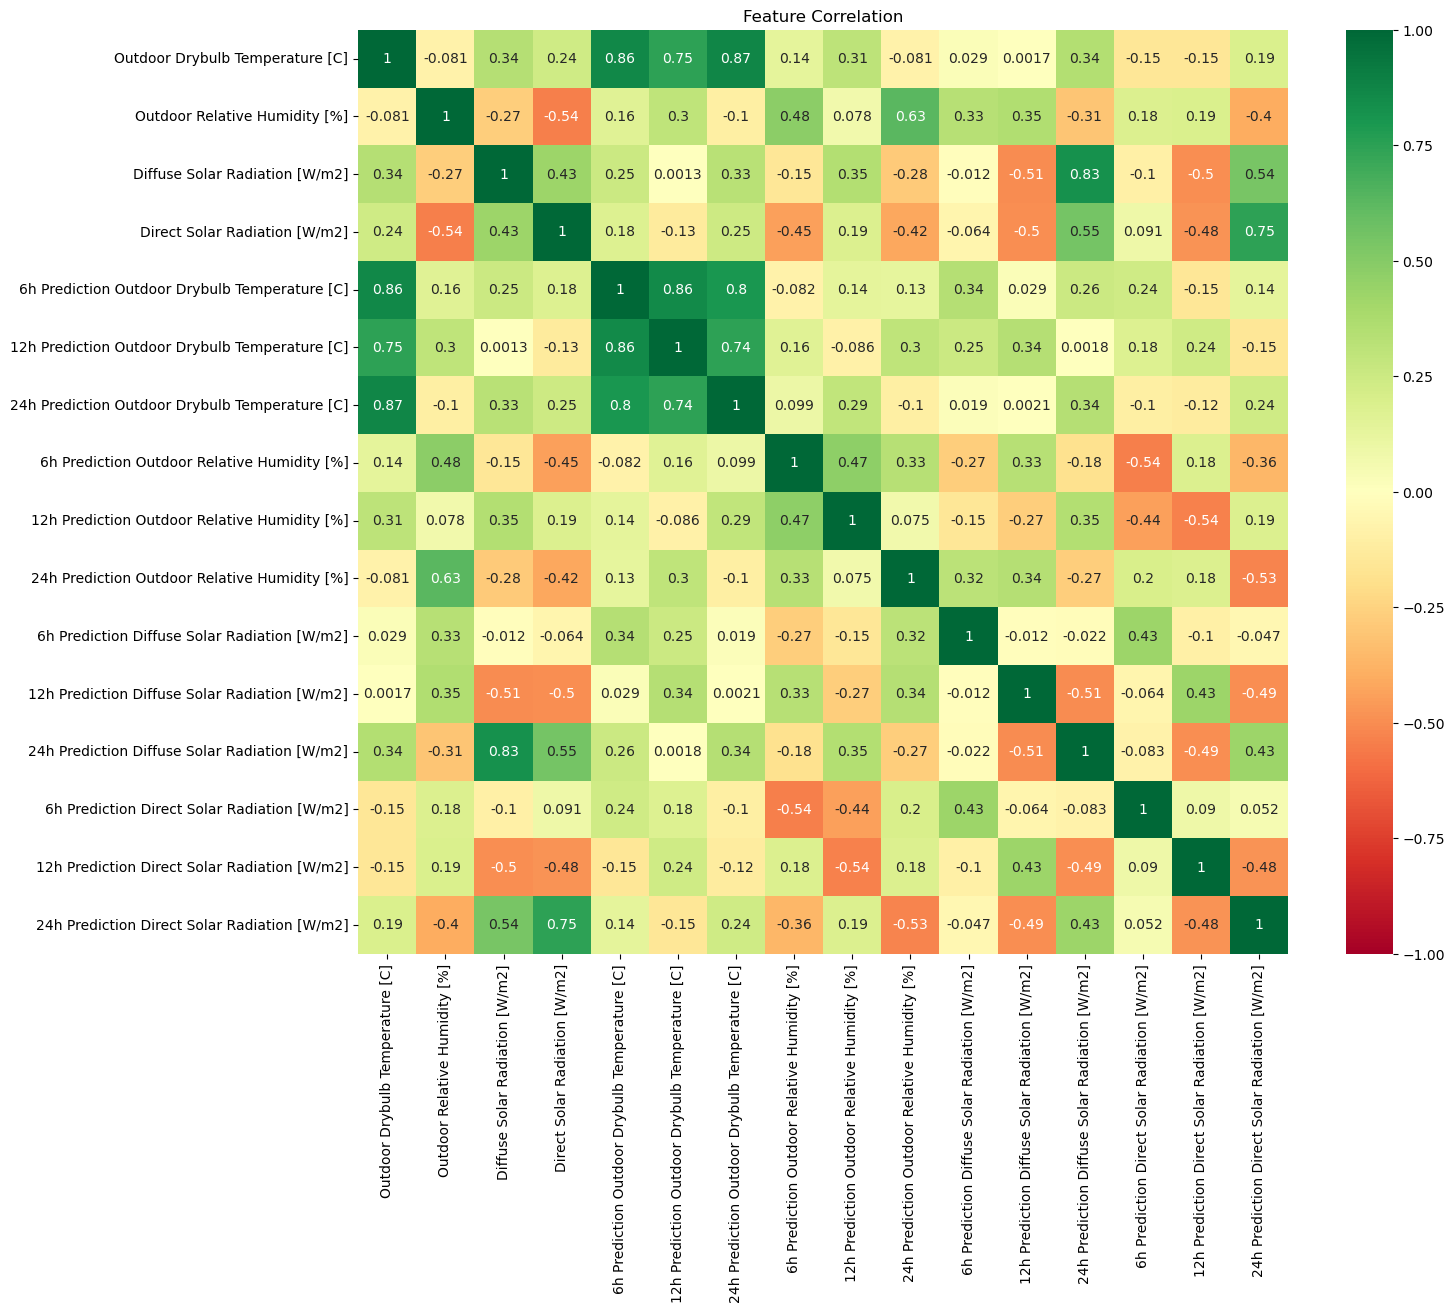

In [24]:
feat_corr(df_weather)

<li>as we see there is high correlation between outdoor Drybulb Temperature [C] and 24h Prediction Outdoor Drybulb Temperature [C], 12h Prediction Outdoor Drybulb Temperature [C],6h Prediction Outdoor Drybulb Temperature [C] so i'll keep outdoor Drybulb Temperature [C] and drop the others.
#24h Prediction Outdoor Drybulb Temperature [C], 12h Prediction Outdoor Drybulb Temperature [C],6h Prediction Outdoor Drybulb Temperature [C] </li>

In [25]:
col_drop_name = ['6h Prediction Outdoor Drybulb Temperature [C]', '12h Prediction Outdoor Drybulb Temperature [C]','24h Prediction Outdoor Drybulb Temperature [C]']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [26]:
df_weather.rename(columns={
        'Outdoor Drybulb Temperature [C]': f'OutdoorDrybulbTemperature',
        'Outdoor Relative Humidity [%]': f'OutdoorRelativeHumidity',
        'Diffuse Solar Radiation [W/m2]': f'DiffuseSolarRadiation',
        'Direct Solar Radiation [W/m2]': f'DirectSolarRadiation',
        '6h Prediction Outdoor Relative Humidity [%]': f'6hPrediction OutdoorRelativeHumidity',
        '12h Prediction Outdoor Relative Humidity [%]': f'12hPredictionOutdoorRelativeHumidity',
        '24h Prediction Outdoor Relative Humidity [%]': f'24hPredictionOutdoorRelativeHumidity',
        '6h Prediction Diffuse Solar Radiation [W/m2]': f'6hPredictionDiffuseSolarRadiation',
        '12h Prediction Diffuse Solar Radiation [W/m2]': f'12hPredictionDiffuseSolarRadiation',
        '24h Prediction Diffuse Solar Radiation [W/m2]': f'24hPredictionDiffuseSolarRadiation',
        '6h Prediction Direct Solar Radiation [W/m2]': f'6hPredictionDirectSolarRadiation',
        '12h Prediction Direct Solar Radiation [W/m2]': f'12hPredictionDirectSolarRadiation',
        '24h Prediction Direct Solar Radiation [W/m2]': f'24hPredictionDirectSolarRadiation',


    }, inplace=True)

In [27]:
df.columns

Index(['Month', 'Hour', 'Day Type', 'Daylight Savings Status',
       'Indoor Temperature [C]',
       'Average Unmet Cooling Setpoint Difference [C]',
       'Indoor Relative Humidity [%]', 'Equipment Electric Power [kWh]',
       'DHW Heating [kWh]', 'Cooling Load [kWh]', 'Solar Generation [W/kW]'],
      dtype='object')

In [28]:
def signal_to_noise_ratio(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal

In [29]:

snr = signal_to_noise_ratio(df['Equipment Electric Power [kWh]'])
print(f'Signal-to-Noise Ratio: {snr}')

Signal-to-Noise Ratio: 3.4438256485639376


In [30]:
df= replace_outliers(df)

In [31]:
df = pd.concat([df, df_weather, df_carbon], axis=1)


In [32]:
df.head()

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],...,6hPrediction OutdoorRelativeHumidity,12hPredictionOutdoorRelativeHumidity,24hPredictionOutdoorRelativeHumidity,6hPredictionDiffuseSolarRadiation,12hPredictionDiffuseSolarRadiation,24hPredictionDiffuseSolarRadiation,6hPredictionDirectSolarRadiation,12hPredictionDirectSolarRadiation,24hPredictionDirectSolarRadiation,kg_CO2/kWh
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1.0,1.0,8.0,0.0,23.11,0.0,55.86,11.7,3.00,1.61,...,91.12,82.93,91.65,-0.00,170.84,0.0,-0.00,5.32,0.0,0.526290
2021-01-01 01:00:00,1.0,2.0,8.0,0.0,23.11,0.0,52.90,7.2,3.36,0.47,...,93.62,88.58,101.62,16.77,112.24,0.0,1.11,2.04,-0.0,0.543741
2021-01-01 02:00:00,1.0,3.0,8.0,0.0,23.11,0.0,50.06,8.1,0.36,0.58,...,94.32,91.52,105.77,40.08,65.93,0.0,1.74,1.04,0.0,0.537555
2021-01-01 03:00:00,1.0,4.0,8.0,0.0,23.11,0.0,47.95,12.4,0.12,1.19,...,90.47,92.86,92.80,65.63,38.59,-0.0,1.09,0.99,0.0,0.534559
2021-01-01 04:00:00,1.0,5.0,8.0,0.0,23.11,0.0,46.91,8.6,0.00,0.59,...,90.63,89.75,100.62,107.26,15.92,0.0,1.78,0.84,0.0,0.537520


In [33]:
df = df[df.index <= '2024-01-01']


In [34]:
df.shape

(26281, 25)

In [35]:
df.columns

Index(['Month', 'Hour', 'Day Type', 'Daylight Savings Status',
       'Indoor Temperature [C]',
       'Average Unmet Cooling Setpoint Difference [C]',
       'Indoor Relative Humidity [%]', 'Equipment Electric Power [kWh]',
       'DHW Heating [kWh]', 'Cooling Load [kWh]', 'Solar Generation [W/kW]',
       'OutdoorDrybulbTemperature', 'OutdoorRelativeHumidity',
       'DiffuseSolarRadiation', 'DirectSolarRadiation',
       '6hPrediction OutdoorRelativeHumidity',
       '12hPredictionOutdoorRelativeHumidity',
       '24hPredictionOutdoorRelativeHumidity',
       '6hPredictionDiffuseSolarRadiation',
       '12hPredictionDiffuseSolarRadiation',
       '24hPredictionDiffuseSolarRadiation',
       '6hPredictionDirectSolarRadiation', '12hPredictionDirectSolarRadiation',
       '24hPredictionDirectSolarRadiation', 'kg_CO2/kWh'],
      dtype='object')

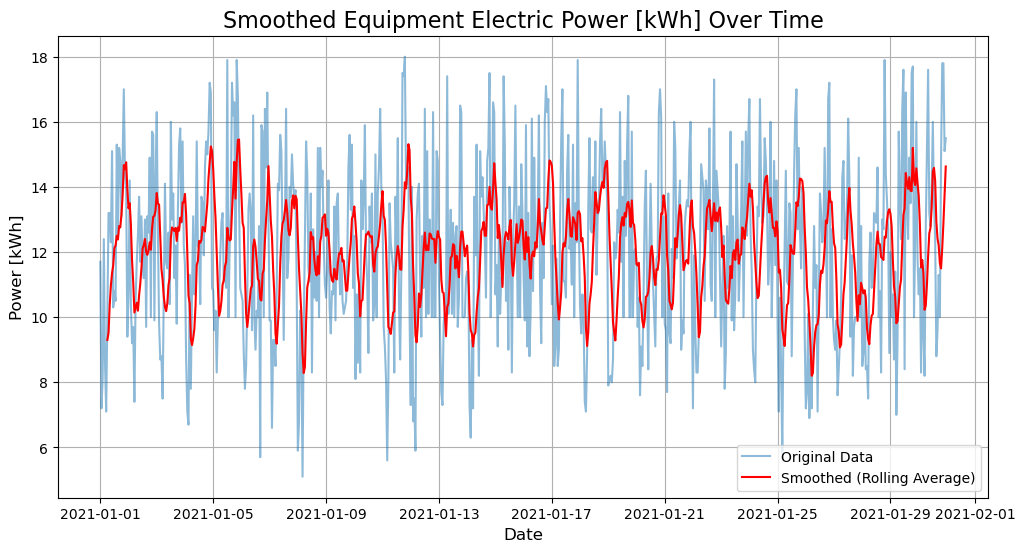

In [36]:

df['Smoothed'] = df['Equipment Electric Power [kWh]'].rolling(window=7).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df.index[:24*30], df['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df.index[:24*30], df['Smoothed'][:24*30], label='Smoothed (Rolling Average)', color='red')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

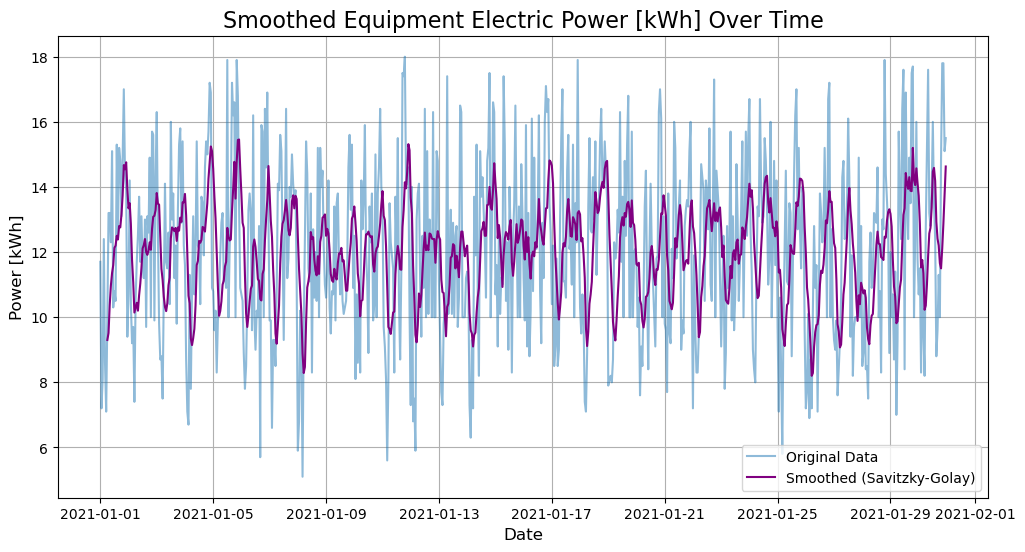

In [37]:
from scipy.signal import savgol_filter

df['Smoothed1'] = savgol_filter(df['Equipment Electric Power [kWh]'], window_length=11, polyorder=2)

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df.index[:24*30], df['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df.index[:24*30], df['Smoothed'][:24*30], label='Smoothed (Savitzky-Golay)', color='purple')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

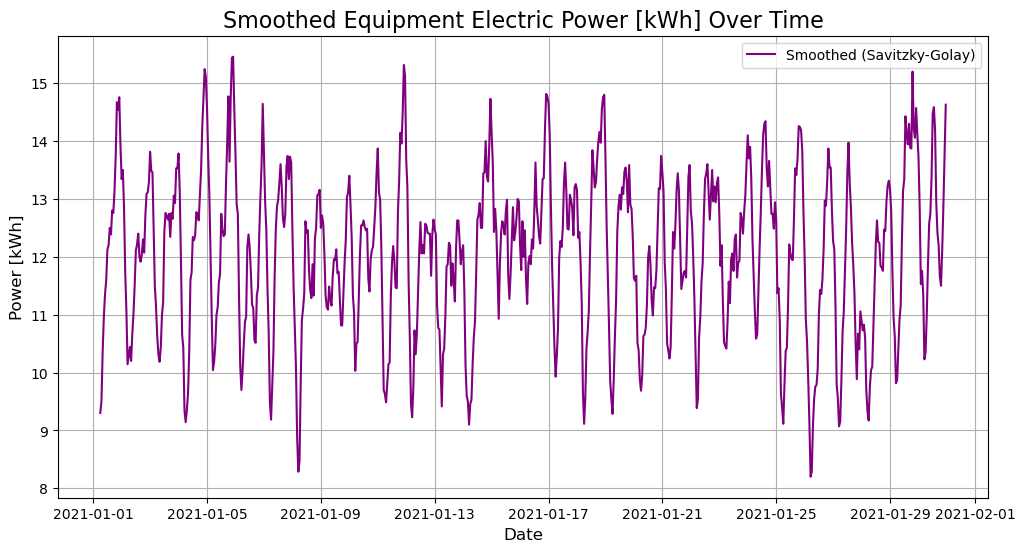

In [38]:
from scipy.signal import savgol_filter

df['Smoothed1'] = savgol_filter(df['Equipment Electric Power [kWh]'], window_length=11, polyorder=2)

# Plot the smoothed data
plt.figure(figsize=(12, 6))

plt.plot(df.index[:24*30], df['Smoothed'][:24*30], label='Smoothed (Savitzky-Golay)', color='purple')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

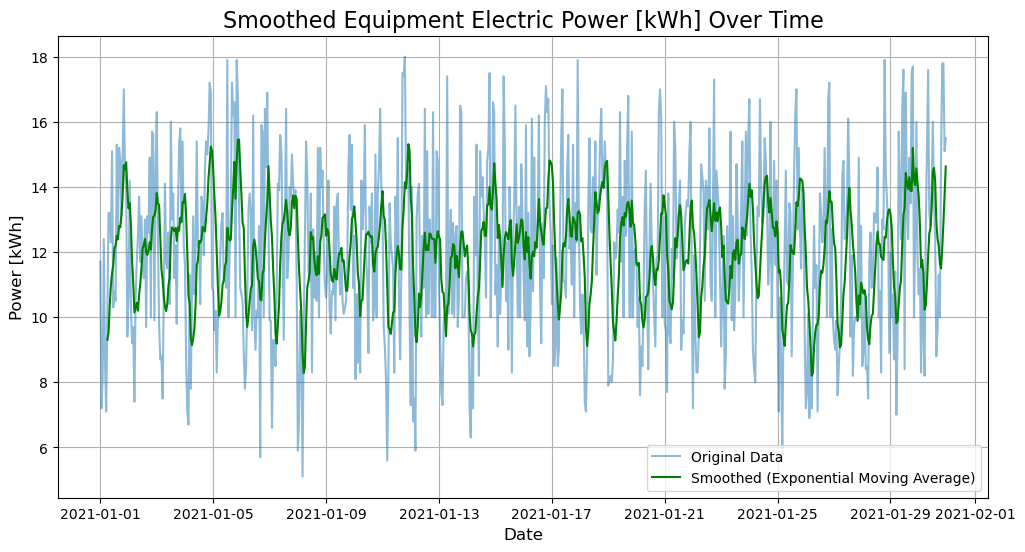

In [39]:
df['Smoothed2'] = df['Equipment Electric Power [kWh]'].ewm(span=10, adjust=False).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df.index[:24*30], df['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df.index[:24*30], df['Smoothed'][:24*30], label='Smoothed (Exponential Moving Average)', color='green')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [40]:
## Correlations

correlation_matrix = df.corr()

target_correlation = correlation_matrix['Smoothed1']

sorted_correlation = target_correlation.sort_values(ascending=False)

print(sorted_correlation)

Smoothed1                                        1.000000
Equipment Electric Power [kWh]                   0.797395
Smoothed2                                        0.720937
Smoothed                                         0.640048
Hour                                             0.577065
12hPredictionOutdoorRelativeHumidity             0.379327
Solar Generation [W/kW]                          0.314714
DiffuseSolarRadiation                            0.304148
24hPredictionDiffuseSolarRadiation               0.303486
Cooling Load [kWh]                               0.283994
DirectSolarRadiation                             0.258015
24hPredictionDirectSolarRadiation                0.257424
DHW Heating [kWh]                                0.230309
kg_CO2/kWh                                       0.200887
Indoor Temperature [C]                           0.112867
6hPrediction OutdoorRelativeHumidity             0.063225
OutdoorDrybulbTemperature                        0.046947
Day Type      

In [41]:
# test stationary 
result = adfuller(df[['Equipment Electric Power [kWh]']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -7.749897963770333
p-value: 1.0085386976512976e-11
Critical Values: {'1%': -3.430599321034093, '5%': -2.8616501925763513, '10%': -2.566828652246847}


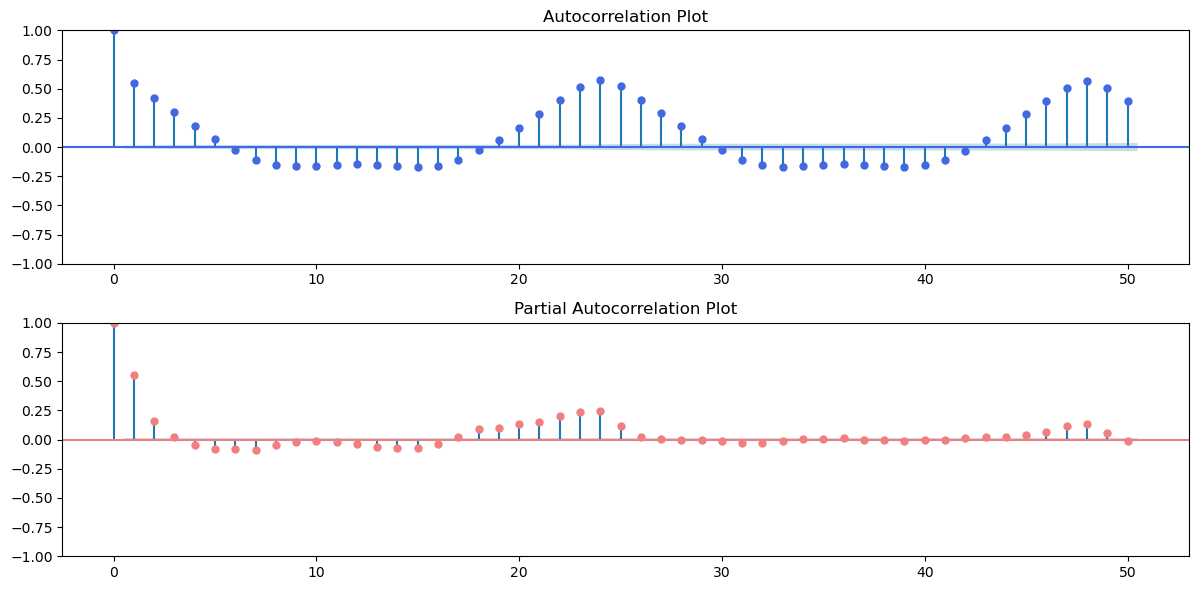

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['Equipment Electric Power [kWh]'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df['Equipment Electric Power [kWh]'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

## Feature Engineering

In [43]:
# Add lag features based on PACF/ACF analysis
df['lag_1'] = df['Smoothed1'].shift(1)
df['lag_2'] = df['Smoothed1'].shift(2)
df['lag_3'] = df['Smoothed1'].shift(3)
df['lag_19'] = df['Smoothed1'].shift(19)
df['lag_20'] = df['Smoothed1'].shift(20)

df['lag_21'] = df['Smoothed1'].shift(21)
df['lag_23'] = df['Smoothed1'].shift(23)
df['lag_24'] = df['Smoothed1'].shift(24)
df['lag_25'] = df['Smoothed1'].shift(25)
df['lag_26'] = df['Smoothed1'].shift(26)


df['lag_47'] = df['Smoothed1'].shift(47)
df['lag_48'] = df['Smoothed1'].shift(48)
df['lag_49'] = df['Smoothed1'].shift(49)




# Add rolling statistics (mean and std) over a 7-day window
df['rolling_mean_7'] = df['Smoothed1'].rolling(window=7).mean()
df['rolling_std_7'] = df['Smoothed1'].rolling(window=7).std()



# Rolling and lagged features for Outdoor Relative Humidity [%]
df["12hPredictionOutdoorRelativeHumidity_rolling_mean_24"] = df["12hPredictionOutdoorRelativeHumidity"].rolling(window=24).mean()
df["12hPredictionOutdoorRelativeHumidity_lag_1"] = df["12hPredictionOutdoorRelativeHumidity"].shift(1)




#12hPredictionOutdoorRelativeHumidity             0.314646
#Indoor Temperature [C]

# Add rolling statistics (mean and std) over a 7-day window
df['rolling_mean_7'] = df['Smoothed1'].rolling(window=7).mean()
df['rolling_std_7'] = df['Smoothed1'].rolling(window=7).std()



# Add sine/cosine encoding for hour of day and month of the year
df["hour_x"] = np.sin(np.radians((360/24) * df.index.hour))
df["hour_y"] = np.cos(np.radians((360/24) * df.index.hour))
df["month_x"] = np.sin(np.radians((360/12) * df.index.month))
df["month_y"] = np.cos(np.radians((360/12) * df.index.month))

# Add calendar-based variables as categorical data
df['hour'] = df.index.hour  # Hour of the day
df['dayofweek'] = df.index.dayofweek  # Day of the week
df['quarter'] = df.index.quarter  # Quarter of the year
df['month'] = df.index.month  # Month of the year
df['year'] = df.index.year  # Year
df['dayofyear'] = df.index.dayofyear  # Day of the year
df['dayofmonth'] = df.index.day  # Day of the month
df['weekofyear'] = df.index.isocalendar().week  # Week of the year


window = df['Smoothed1'].expanding()

dataframe = pd.concat([window.min(), window.mean(), window.max(), df['Smoothed1'].shift(-1)], axis=1)

dataframe.columns = ['min_5', 'mean_5', 'max_5', 't+1_5']


df = pd.concat([dataframe, df ], axis=1)

df.shape


(26281, 61)

In [44]:
df = df.drop(columns=['Smoothed', 'Smoothed2', 'Equipment Electric Power [kWh]','Month','Daylight Savings Status','Average Unmet Cooling Setpoint Difference [C]'])

In [45]:
df.isnull().sum()
df = df.dropna()

In [46]:
df.shape

(26231, 55)

## Feature Selection for Building 5

In [47]:

X = df.drop(['Smoothed1'], axis = 1)
y= df[['Smoothed1']]


In [48]:
y.shape

(26231, 1)

In [49]:
n_features = 19
X_pca = apply_PCA(X, n_features=n_features)

# Output the shape of the transformed data
print(X_pca.shape)  # This should be (n_samples, 17)

(26231, 19)


X_pca = apply_PCA(X, **params_pca)
print(X_pca.shape)

In [50]:
y.shape

(26231, 1)

In [51]:
train_cutoff = int(0.6*X_pca.shape[0])
val_cutoff   = int(0.8*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

In [52]:
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

In [53]:
# History size and horizon size
hist_size = 24
horizon_size = 24

# Get the windows
#data, labels = windowing(X_input, y_input, history_size, horizon_size)
X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size, horizon_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size, horizon_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size, horizon_size)

In [54]:
print('X_train is:', X_train.shape)
print('y_train is:', y_train.shape)
print('X_val is:', X_val.shape)
print('y_val is:', y_val.shape)
print('X_test is:', X_test.shape)
print('y_test is:', y_test.shape)


X_train is: (15691, 24, 20)
y_train is: (15691, 24)
X_val is: (5199, 24, 20)
y_val is: (5199, 24)
X_test is: (5200, 24, 20)
y_test is: (5200, 24)


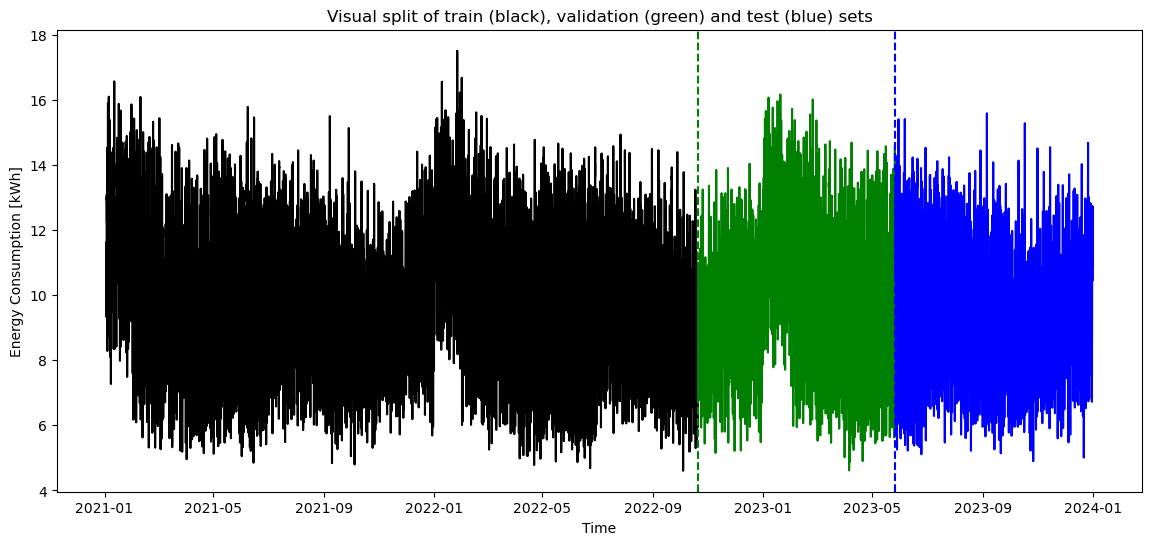

In [55]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df['Smoothed1'].iloc[:train_cutoff], color = 'black')
axes.plot(df['Smoothed1'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df['Smoothed1'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Time')
axes.set_ylabel('Energy Consumption [kWh]')
plt.show()


## Forecasting
## 1. XGBoost

In [56]:
X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [57]:
X_train_xgb.shape

(15691, 480)

In [58]:
X_val_xgb.shape

(5199, 480)

In [220]:
X_test_xgb.shape

(5200, 480)

In [221]:
import time 
# Convert your dataset into DMatrix (required by XGBoost for training)
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dval = xgb.DMatrix(X_val_xgb, label=y_val)
dtest = xgb.DMatrix(X_test_xgb)

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'alpha': 0.1,                 # Lower L1 regularization to avoid underfitting
    'lambda': 0.5,                # Lower L2 regularization to allow more learning capacity
    'gamma': 0.1,                 # Lower regularization to allow more splits
    'eval_metric': 'mae',         # Evaluation metric (can be adjusted)
    'colsample_bytree': 0.8,      # Feature sampling
    'learning_rate': 0.01,        # Lower learning rate for gradual learning
    'max_depth': 6,               # Medium tree depth to capture complexity
    'min_child_weight': 3,        # Regularization to avoid small sample splits
    'subsample': 0.8              # Subsampling the data to prevent overfitting
}

# Start the timer
start = time.time()

# Initialize an empty dictionary to store evaluation results
evals_result = {}


# Train the XGBoost model and populate evals_result with metrics
xgb_model = xgb.train(params, dtrain, num_boost_round=1000,  # Reduced boosting rounds
                            evals=[(dtrain, 'train'), (dval, 'eval')], 
                            early_stopping_rounds=200,  # Stop earlier to prevent overfitting
                            evals_result=evals_result,  # Store the results here
                            verbose_eval=50) 

# End the timer
end = time.time()

# Output the runtime
print("Run time [s] for XGBRegressor model is: ", end - start, " Seconds")

[0]	train-mae:0.14005	eval-mae:0.13432
[50]	train-mae:0.09631	eval-mae:0.09622
[100]	train-mae:0.07329	eval-mae:0.07737
[150]	train-mae:0.06197	eval-mae:0.06870
[200]	train-mae:0.05656	eval-mae:0.06486
[250]	train-mae:0.05374	eval-mae:0.06315
[300]	train-mae:0.05222	eval-mae:0.06240
[350]	train-mae:0.05133	eval-mae:0.06204
[400]	train-mae:0.05081	eval-mae:0.06185
[450]	train-mae:0.05053	eval-mae:0.06177
[500]	train-mae:0.05042	eval-mae:0.06173
[550]	train-mae:0.05037	eval-mae:0.06172
[600]	train-mae:0.05033	eval-mae:0.06171
[650]	train-mae:0.05031	eval-mae:0.06170
[700]	train-mae:0.05029	eval-mae:0.06170
[750]	train-mae:0.05028	eval-mae:0.06169
[800]	train-mae:0.05027	eval-mae:0.06169
[850]	train-mae:0.05026	eval-mae:0.06169
[900]	train-mae:0.05025	eval-mae:0.06169
[950]	train-mae:0.05024	eval-mae:0.06169
[999]	train-mae:0.05024	eval-mae:0.06169
Run time [s] for XGBRegressor model is:  502.091908454895  Seconds


In [222]:
y_pred = xgb_model.predict(dtest) 



---------------------------------------------------
TL_model_loaded MAE for test set : 0.705
TL_model_loaded MSE for test set : 0.805
TL_model_loaded RMSE for test set : 0.897
TL_model_loaded MPE for test set : -1.028 %
TL_model_loaded MAPE for test set : 7.481 %
---------------------------------------------------



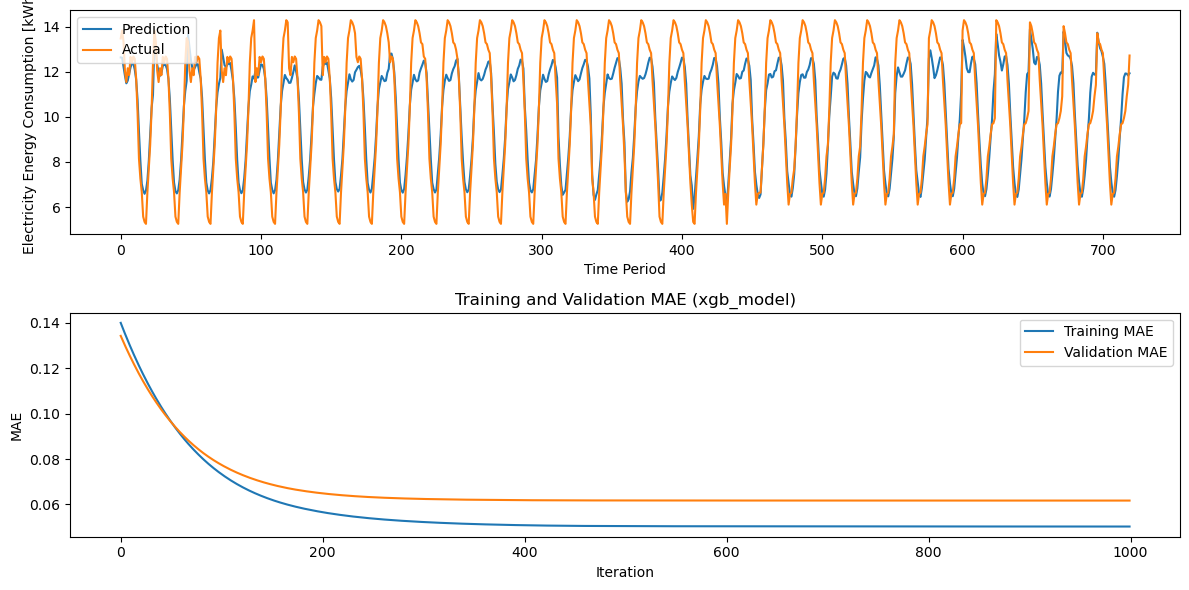

In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1) for scaler
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Ensure shape matches inverse transform

# Calculate the metrics using the inverse-transformed values
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)

# Calculate MPE (Mean Percentage Error)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100  # Mean percentage error
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100

# Print out the metrics
print('')
print('')
print('---------------------------------------------------')
print(f'TL_model_loaded MAE for test set : {round(mae, 3)}')
print(f'TL_model_loaded MSE for test set : {round(mse, 3)}')
print(f'TL_model_loaded RMSE for test set : {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Now call the function and pass evals_result instead of the model
plot_results_xgboost(y_pred_actual, y_test_inv, evals_result, 'xgb_model')

## 2. FineTune MEthod

In [59]:
# Load the saved XGBoost model
xgb_model_loaded = xgb.Booster()  # Initialize an empty Booster object
xgb_model_loaded.load_model('Building_7NEW_model_cluster3.json')

In [63]:
train_size = int(0.6 * len(X_train))
val_size = int(0.6 * len(X_val))
test_size = int(0.6 * len(X_test))

# Slice the first 20% for each dataset
X_train_xgb= reshaping(X_train[:train_size])
X_val_xgb = reshaping(X_val[:val_size])
X_test_xgb = reshaping(X_test[:test_size])

In [64]:
import time
# Convert your dataset into DMatrix (required by XGBoost for training)
dtrain = xgb.DMatrix(X_train_xgb, label=y_train[:train_size])
dval = xgb.DMatrix(X_val_xgb, label=y_val[:val_size])
dtest = xgb.DMatrix(X_test_xgb)

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'alpha': 0.1,                 # Lower L1 regularization to avoid underfitting
    'lambda': 0.5,                # Lower L2 regularization to allow more learning capacity
    'gamma': 0.1,                 # Lower regularization to allow more splits
    'eval_metric': 'mae',         # Evaluation metric (can be adjusted)
    'colsample_bytree': 0.8,      # Feature sampling
    'learning_rate': 0.01,        # Lower learning rate for gradual learning
    'max_depth': 6,               # Medium tree depth to capture complexity
    'min_child_weight': 3,        # Regularization to avoid small sample splits
    'subsample': 0.8              # Subsampling the data to prevent overfitting
}

# Start the timer
start = time.time()

# Initialize an empty dictionary to store evaluation results
evals_result = {}

# Train the XGBoost model and populate evals_result with metrics
TL_model_loaded = xgb.train(params, dtrain, num_boost_round=1000,  # Increased boosting rounds
                            evals=[(dtrain, 'train'), (dval, 'eval')], 
                            early_stopping_rounds=200,  # Adjusted early stopping
                            evals_result=evals_result,  # Store the results here
                            xgb_model=xgb_model_loaded,
                            verbose_eval=50) 

# End the timer
end = time.time()

# Output the runtime
print("Run time [s] for XGBRegressor model is: ", end - start, " Seconds")

[0]	train-mae:0.13171	eval-mae:0.12465
[50]	train-mae:0.09320	eval-mae:0.09414
[100]	train-mae:0.07231	eval-mae:0.07891
[150]	train-mae:0.06175	eval-mae:0.07163
[200]	train-mae:0.05656	eval-mae:0.06824
[250]	train-mae:0.05392	eval-mae:0.06667
[300]	train-mae:0.05252	eval-mae:0.06588
[350]	train-mae:0.05176	eval-mae:0.06548
[400]	train-mae:0.05134	eval-mae:0.06529
[450]	train-mae:0.05116	eval-mae:0.06520
[500]	train-mae:0.05109	eval-mae:0.06516
[550]	train-mae:0.05105	eval-mae:0.06514
[600]	train-mae:0.05103	eval-mae:0.06513
[650]	train-mae:0.05101	eval-mae:0.06512
[700]	train-mae:0.05099	eval-mae:0.06511
[750]	train-mae:0.05098	eval-mae:0.06511
[800]	train-mae:0.05097	eval-mae:0.06510
[850]	train-mae:0.05096	eval-mae:0.06510
[900]	train-mae:0.05095	eval-mae:0.06509
[950]	train-mae:0.05094	eval-mae:0.06509
[999]	train-mae:0.05094	eval-mae:0.06509
Run time [s] for XGBRegressor model is:  388.6210186481476  Seconds




---------------------------------------------------
TL_model_loaded MAE for test set : 0.675
TL_model_loaded MSE for test set : 0.729
TL_model_loaded RMSE for test set : 0.854
TL_model_loaded MPE for test set : -1.253 %
TL_model_loaded MAPE for test set : 7.097 %
---------------------------------------------------



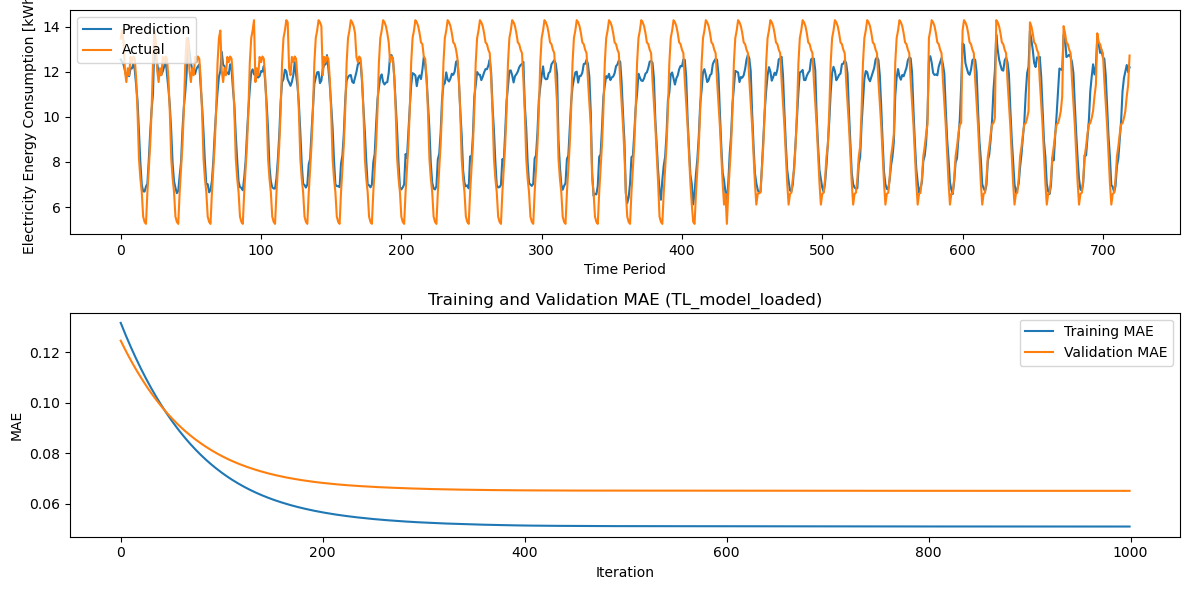

In [65]:
import xgboost as xgb
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = TL_model_loaded.predict(dtest)

# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1) for scaler
y_test_inv = scaler_y.inverse_transform(y_test[:test_size].reshape(-1, 1))  # Ensure shape matches inverse transform

# Calculate the metrics using the inverse-transformed values
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100


# Calculate MPE (Mean Percentage Error)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100  # Mean percentage error

# Print out the metrics
print('')
print('')
print('---------------------------------------------------')
print(f'TL_model_loaded MAE for test set : {round(mae, 3)}')
print(f'TL_model_loaded MSE for test set : {round(mse, 3)}')
print(f'TL_model_loaded RMSE for test set : {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Now call the function and pass evals_result instead of the model
plot_results_xgboost(y_pred_actual, y_test_inv, evals_result, 'TL_model_loaded')
